In [14]:
import pandas as pd
import numpy as np

In [15]:
# load full_info_dataframe.csv
data_full = pd.read_csv('../merged_data/full_info_dataframe.csv', sep=",")

/var/folders/7_/wb06s1193t5fbc2j9sggjlj80000gn/T/ipykernel_47113/59176.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data_full = pd.read_csv('../merged_data/full_info_dataframe.csv', sep=",")


In [20]:
data_full.head()

,client_id,visitor_id,visit_id,process_step,date_time,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,5.0,64.0,79.0,NaN,2.0,189023.86,1.0,4.0,Test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,5.0,64.0,79.0,NaN,2.0,189023.86,1.0,4.0,Test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,5.0,64.0,79.0,NaN,2.0,189023.86,1.0,4.0,Test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,5.0,64.0,79.0,NaN,2.0,189023.86,1.0,4.0,Test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:17:15,5.0,64.0,79.0,NaN,2.0,189023.86,1.0,4.0,Test


In [16]:
data_full['Variation'].unique()

array(['Test', 'Control', nan], dtype=object)

In [17]:
data_full['process_step'].unique()

array(['step_2', 'step_3', 'step_1', 'start', 'confirm'], dtype=object)

In [18]:
# Remove rows where 'Variation' is NaN (we only want 'Test' and 'Control' users)
data_full = data_full.dropna(subset=['Variation'])

In [19]:
# Convert the 'date_time' column to datetime format for time calculations
data_full['date_time'] = pd.to_datetime(data_full['date_time'])

In [21]:
# Sort the data by user and timestamp to ensure correct time difference calculations
data_sorted = data_full.sort_values(by=['visitor_id', 'visit_id', 'date_time'])

In [22]:
# Calculate the time difference between each step and the next step within each visit
# This gives the time spent on the current step before moving to the next one
data_sorted['time_diff'] = data_sorted.groupby(['visitor_id', 'visit_id'])['date_time'].diff().shift(-1)

In [23]:
# Separate the data into Test and Control groups
df_test = data_sorted[data_sorted['Variation'] == 'Test']
df_control = data_sorted[data_sorted['Variation'] == 'Control']

In [26]:
# Group by process_step and calculate the average time spent on each step (for Test group)
avg_time_test = df_test.groupby('process_step')['time_diff'].mean()

In [ ]:
# Group by process_step and calculate the average time spent on each step (for Control group)
avg_time_control = df_control.groupby('process_step')['time_diff'].mean()

In [27]:
# Function to format timedelta into MM:SS
def format_timedelta(td):
    if pd.isnull(td):
        return None
    total_seconds = int(td.total_seconds())
    minutes, seconds = divmod(total_seconds, 60)
    return f"{minutes:02}:{seconds:02}"


# Apply formatting to both groups
avg_time_test_formatted = avg_time_test.apply(format_timedelta)
avg_time_control_formatted = avg_time_control.apply(format_timedelta)

In [28]:
# Show the results
print("Average time spent on each step (Test group):")
print(avg_time_test)

print("\nAverage time spent on each step (Control group):")
print(avg_time_control)

Average time spent on each step (Test group):
process_step
confirm   0 days 00:04:10.566239316
start     0 days 00:01:01.454594512
step_1    0 days 00:01:00.756987249
step_2    0 days 00:01:28.878579881
step_3    0 days 00:02:09.607488325
Name: time_diff, dtype: timedelta64[ns]

Average time spent on each step (Control group):
process_step
confirm   0 days 00:03:00.146050670
start     0 days 00:01:06.804756575
step_1    0 days 00:00:50.535582680
step_2    0 days 00:01:32.043222569
step_3    0 days 00:02:17.224495833
Name: time_diff, dtype: timedelta64[ns]


In [29]:
# Display the results
print("Average time spent on each step (Test group):")
print(avg_time_test_formatted)

print("\nAverage time spent on each step (Control group):")
print(avg_time_control_formatted)

Average time spent on each step (Test group):
process_step
confirm    04:10
start      01:01
step_1     01:00
step_2     01:28
step_3     02:09
Name: time_diff, dtype: object

Average time spent on each step (Control group):
process_step
confirm    03:00
start      01:06
step_1     00:50
step_2     01:32
step_3     02:17
Name: time_diff, dtype: object


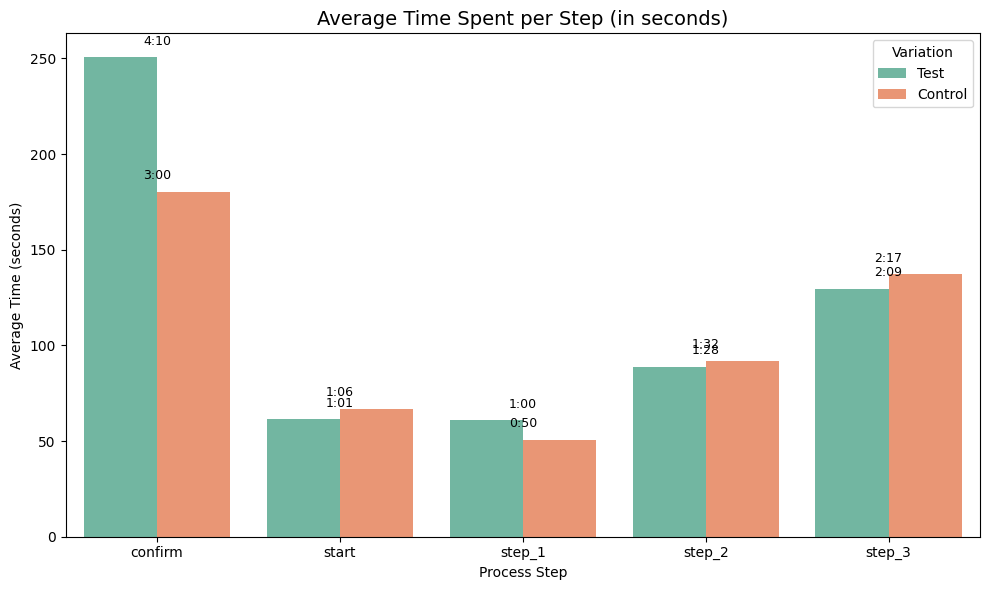

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine both series into a DataFrame for plotting
# First, convert the timedelta to total seconds for easier plotting
avg_time_df = pd.DataFrame({
    'Test': avg_time_test.dt.total_seconds(),
    'Control': avg_time_control.dt.total_seconds()
})

# Reset index to get 'process_step' as a column
avg_time_df = avg_time_df.reset_index()

# Melt the DataFrame to long format for Seaborn
avg_time_melted = avg_time_df.melt(id_vars='process_step', var_name='Variation', value_name='Seconds')

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_time_melted, x='process_step', y='Seconds', hue='Variation', palette='Set2')

# Add labels and title
plt.title('Average Time Spent per Step (in seconds)', fontsize=14)
plt.ylabel('Average Time (seconds)')
plt.xlabel('Process Step')

# Optional: Add time labels on top of each bar
for index, row in avg_time_melted.iterrows():
    minutes = int(row['Seconds'] // 60)
    seconds = int(row['Seconds'] % 60)
    label = f"{minutes}:{seconds:02}"
    plt.text(
        x=index % len(avg_time_df['process_step'].unique()),  # position x
        y=row['Seconds'] + 5,  # position y (slightly above the bar)
        s=label,
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()